In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


import pm4py
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.petri_net.utils import petri_utils

from pm4py.algo.analysis.woflan.graphs import utility as helper




In [2]:
path = "datasets/alpha_miner/bpi2017_alpha_petri_net.pnml"

In [3]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pn, im, fm = pm4py.read_pnml(path)

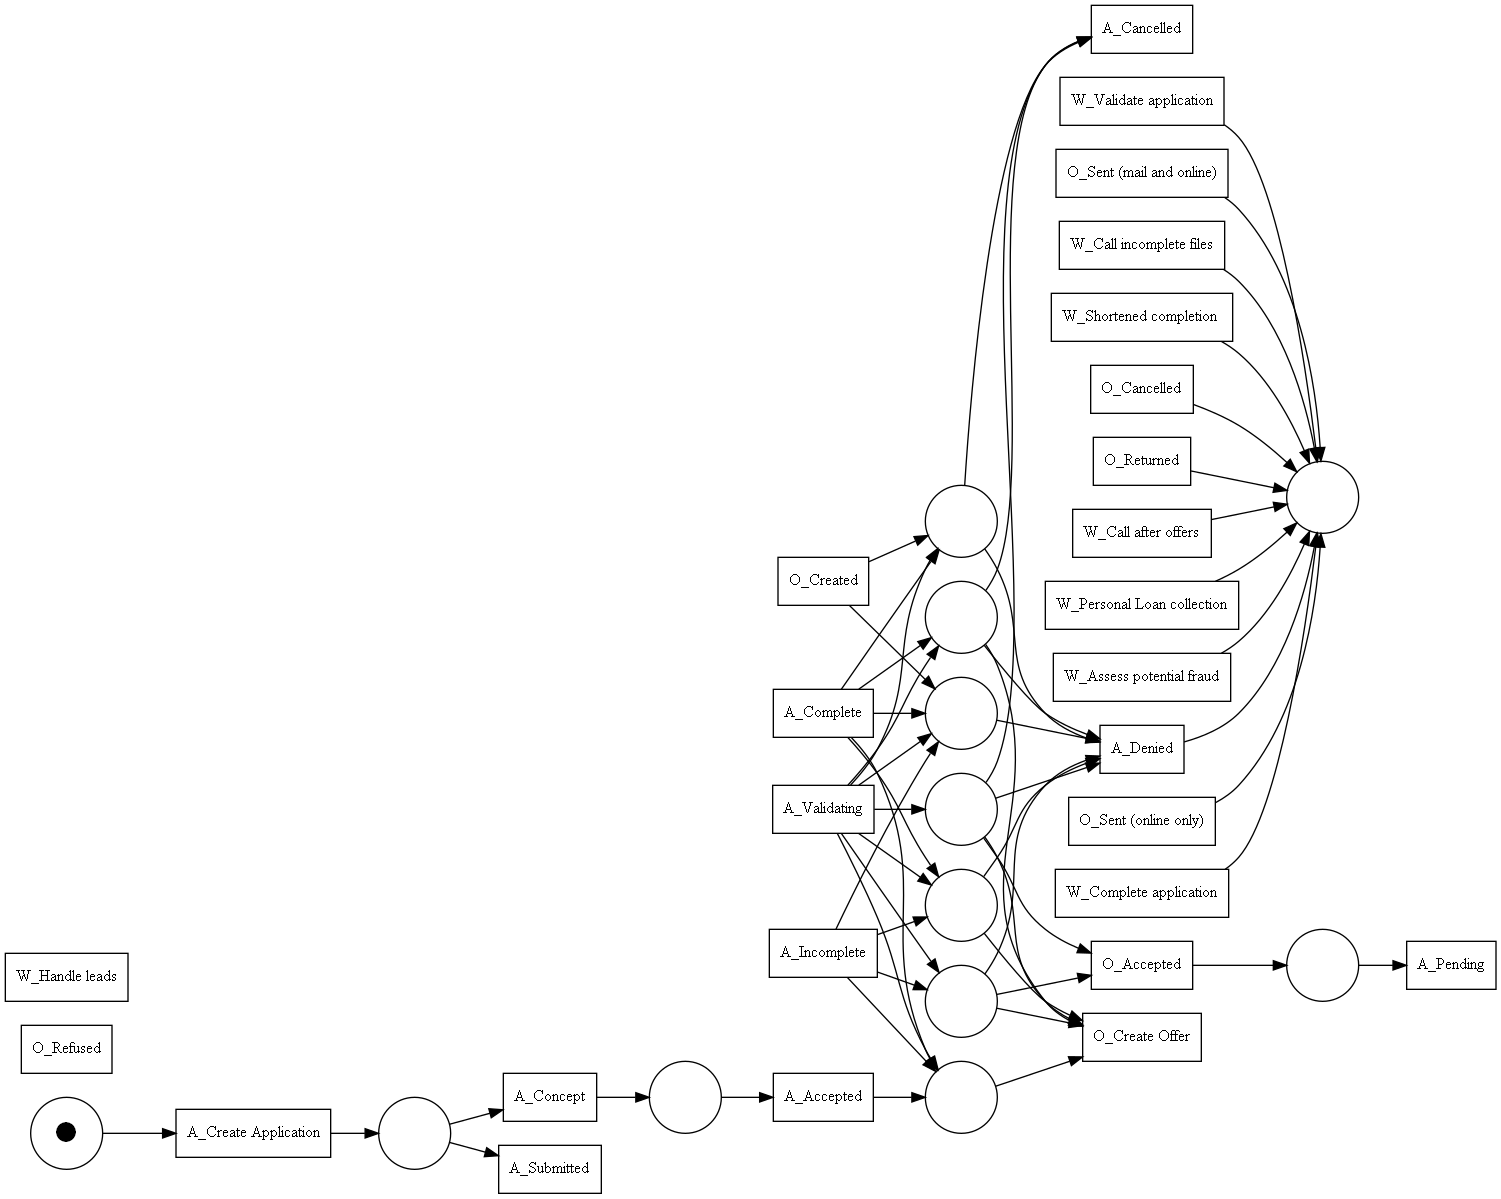

In [4]:
pm4py.view_petri_net(pn,im)

In [5]:
name_list = [trans.name for trans in list(pn.transitions)]

from itertools import permutations

def generate_3_permutations(input_list):
    # Generate all permutations of length 3 of the input list
    all_3_permutations = permutations(input_list, 3)

    # Convert each permutation to a list and collect them in a list
    result_list = [list(permutation) for permutation in all_3_permutations]

    return result_list

result = generate_3_permutations(name_list)


perm_list = []
perm_set = []
# Print the result
for perm in result:
    perm_list.append(perm)
print(f"The number of transitions are {len(name_list)} and the number of 3-tuple permutations are {len(perm_list)}")


The number of transitions are 26 and the number of 3-tuple permutations are 15600


In [6]:
d_im = dict(im)#temp variable


d_im = {str(key): value for key, value in d_im.items()}

places = list(pn.places)
places = [str(place) for place in places]
places.sort()


In [7]:
dict_im={}
m0=[]
for place in places:
    #print(place)
    if place in d_im:
        dict_im[place]= d_im[place]
        m0.append(d_im[place])
    else:
        dict_im[place]=0
        m0.append(0)


dict_im = dict(sorted(dict_im.items())) #get a sorted version of the dictionary

In [8]:
#In this section we are defining the D matrices of the Petri net that we will later use for our calculations

original_net=None
incidence_matrix = helper.compute_incidence_matrix(pn)
firing_dict = helper.split_incidence_matrix(incidence_matrix, pn)
req_dict = helper.compute_firing_requirement(pn)

initial_mark = helper.convert_marking(pn, im, original_net=None)





D=[]
Dm=[]
Dp=[]

for key, value in firing_dict.items(): #convert to list (D)
    value = firing_dict[key]
    D.append([key.name, list(value)])
    #print(f"  {key}: {value}")

for key,value in req_dict.items():#convert to list (Dm)

    value = req_dict[key]
    Dm.append([key.name, list(value)])
    #print(f"  {key}: {value}")

#The way they are represented D = Dm+Dp, => Dp = D-Dm


Dp = [
    [str1, [int1 - int2 for int1, int2 in zip(inner_list1, inner_list2)]]
    
    for str1, inner_list1 in D
    for str2, inner_list2 in Dm
    if str1 == str2
]


In [9]:
#Here we are defining functions that we will later use to generate the coverability graph of the Petri net


def en_dis(value):
    if value==1:
        return "enabled"
    else:
        return "disabled"
    
def great_eq_checker(a,b):
    if (a>=b):
        return True
    else:
        return False
    
  
#dict_im

def check_enabled_transitions(M):
    #tees = len(Dm) #could be any of the D matrices
    enabled_states = []
    for index,transition in enumerate(Dm):
        #print(f"index is {index}, transition is {type(transition[1])} and M is {type(M)}")
        #print (transition[1]+M)
        #print(f"transition+M >= 0 is:  {transition+M >= 0}")
        x=np.prod(np.array(transition[1]) + np.array(M) >= 0)
        #print(f" Transition {transition[0]} is {en_dis(x) }")
        enabled_states.append([transition[0], int(x)]) 
    return enabled_states
        

def enabled_transitions(M):
    transitions = check_enabled_transitions(M)
    en_transitions = [sublist for sublist in transitions if sublist[1]==1]
    return en_transitions




def new_marking(M,t): #t = transition (str)
    return list(np.array(M) +  np.array(dict(D)[t]))


 

def check_Mpp_neq_Mp(Mpp,Mp):
    return Mpp==Mp


def check_Mpp_subeq_Mp(Mpp,Mp):
    checklist = []
    covered_places=[]
    
    for index,element in enumerate(Mpp):
        if Mpp[index]<=Mp[index]:
            checklist.append(True)
        else:
            checklist.append(False)
        
         
    result=np.array(checklist).prod()
    #in case the marking is covered then we check the places where
    #M'(p)>M''(p)
    
    if (result==1):
        for index,element in enumerate(Mpp):
            if Mpp[index]<Mp[index]:
                covered_places.append(index) #in all the other cases I will not be replacing the number of tokens with an omega               
    return result,covered_places




def set_omegas(covered_places,Mp): #covered places is just a list of indices
    for index in covered_places:
        Mp[index]=np.inf
         

In [10]:
##coverability graph code is here
d=0
node_counter=0
mlist=[[node_counter, m0]]
all_markings = [[node_counter, m0]]

G = nx.MultiDiGraph()
G.add_node(node_counter, marking= m0)
source=0
expanding_root=True



for node_number, marking in mlist:
    en_tran = enabled_transitions(marking)
    en_tran = [sublist[0] for sublist in en_tran if sublist[1] == 1]
    expanded_markings=[]
    n_active_t = len(en_tran) #number of active transitions in "marking"
    if (n_active_t>0):
        for transition in en_tran:
            node_counter+=1
            expanded_markings.append([node_counter, new_marking(marking,transition), transition])
        expanded_markings_only = [sublist[1] for sublist in expanded_markings]  
        #check with parent
        if (expanding_root):
            expanding_root = False #we just want this for the root - no path to itself
            for ncounter, Mp, i_transition in expanded_markings:
                res,cov_places = check_Mpp_subeq_Mp(marking,Mp) #marking=Mpp
                if (res==1):
                    set_omegas(cov_places, Mp) #(list,list)->list
                if Mp not in [sublist[1] for sublist in all_markings]:
                    #print(f"Mp is {Mp} and the list I check is {[sublist[1] for sublist in all_markings]}")
                    all_markings.append([ncounter,Mp])
                    mlist.append([ncounter,Mp])
                    G.add_node(ncounter, marking= Mp)
                    G.add_edge(source, ncounter, transition = i_transition)
                if Mp == marking: #case where one of the expanded markings is itself, FURTHER TESTING NEEDED HERE
                    G.add_edge(source,source,transition = i_transition)
                
        #end of check with parent
        #check with all
        else:
            all_paths = list(nx.all_simple_paths(G, 0 , node_number))  #0=root always the source, nodecounter=parent always the target, returns list of lists
            for ncounter, Mp, i_transition in expanded_markings:
                for path in all_paths: #path is a list
                    for indexMpp, Mpp in enumerate(path):
                        Mpp_marking=[element for element in mlist if element[0]==Mpp][0][1] #Mpp=node_number, Mpp_marking=corresponding marking
                        res,cov_places = check_Mpp_subeq_Mp(Mpp_marking,Mp) #marking=Mpp parent is "marking"
                        if (res==1):
                            set_omegas(cov_places, Mp) #(list,list)->list
                if Mp not in [sublist[1] for sublist in all_markings]:
                    all_markings.append([ncounter,Mp])
                    mlist.append([ncounter,Mp])
                    G.add_node(ncounter, marking= Mp)
                    G.add_edge(node_number, ncounter, transition = i_transition) 
                if Mp == marking: #case where one of the expanded markings is itself
                    G.add_edge(node_number,node_number,transition = i_transition)
        

In [11]:
#print the coverability graph
for node, attributes in G.nodes(data=True):
    print(f"Node: {node}, Attributes: {attributes}")

print()
for source, target, attributes in G.edges(data=True):
    print(f"Edge: {source} - {target}, Attributes: {attributes}")




Node: 0, Attributes: {'marking': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
Node: 1, Attributes: {'marking': [0.0, inf, 1.0, 0.0, 0.0, 0.0, inf, inf, inf, inf, inf, inf]}
Node: 2, Attributes: {'marking': [0.0, inf, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, inf, 0.0, 0.0]}
Node: 3, Attributes: {'marking': [0.0, 0.0, 1.0, inf, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
Node: 6, Attributes: {'marking': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
Node: 14, Attributes: {'marking': [0.0, inf, 1.0, 0.0, 0.0, 0.0, 0.0, inf, inf, inf, 0.0, inf]}
Node: 15, Attributes: {'marking': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, inf, inf, inf, inf, 0.0]}
Node: 20, Attributes: {'marking': [0.0, inf, 1.0, inf, 0.0, 0.0, inf, inf, inf, inf, inf, inf]}
Node: 26, Attributes: {'marking': [0.0, inf, 0.0, 0.0, 0.0, 1.0, inf, inf, inf, inf, inf, inf]}
Node: 37, Attributes: {'marking': [inf, inf, 1.0, 0.0, 0.0, 0.0, inf, inf, inf, inf, inf, inf]}
Node: 43, Attributes: {'marking': [0.0, inf, 1.0, inf, 0.0, 0.0, 0.0,

In [12]:
#check whether c is only enabled when d==0
#Our proposed model checking algorithm is here


myedges=[] #the edges are the transitions of the coverability graph
for source, target, attributes in G.edges(data=True):
    myedges.append([source,target,attributes["transition"]])

mynodes=[] #the markings are the nodes of the coverability graph
for node, attributes in G.nodes(data=True):
    mynodes.append([node,attributes["marking"]])



def reachable_markings(node_num):
    return [element for element in myedges if element[0]==node_num]
    
def dummyfunction(transitions):

    StatesD=[(m0,0,0)] #marking, d, node_number(to expand to reachable markings)
    counter=0
    d=0
    #counter=how many states have been expanded
    #len(StatesD)=total number of states checked and expanded
    #when counter==len(StatesD) then all the paths have been checked without condition violation
    while counter<len(StatesD):
        
        #expand marking M, to all reachable markings
        nodeNum_to_expand = StatesD[counter][2]

        for nodeNum, targetNum, itransition in reachable_markings(nodeNum_to_expand):
            d=StatesD[counter][1]
            target_marking = [element[1] for element in mynodes if element[0]==targetNum][0]

            if itransition==transitions[0]:
                d+=1
            if itransition==transitions[1]:
                d-=1
            if itransition==transitions[2] and d!=0:
                return False
            for mark, diff, nodeN in StatesD:
                if mark==target_marking and diff!=d:
                    d=np.inf
            if [target_marking,d,targetNum] not in StatesD:
                StatesD.append([target_marking,d,targetNum])
                       
        #print("\n \nState checked\n \n")
        counter+=1
        #print(f"counter, length pairs {counter, len(StatesD)}")
        #print(f"elements of statesD so far are {StatesD}")
    
    return True




In [13]:
#To calculate the time needed for all the possible query combinations

import time

start_time = time.time()

for element in perm_list:
    dummyfunction(element)

end_time = time.time()
print(f"The average query time was {(end_time-start_time)/len(perm_list)} seconds")    

The average query time was 0.006314324599045974 seconds


In [14]:
#To calculate the % of true queries, for all the possible query combinations
truth_counter = 0
test_list=[]


start_time = time.time()

for element in perm_list:
    truth_counter+=dummyfunction(element)

end_time = time.time()
print(f"The % of queries that hold true are {truth_counter*100/len(perm_list)}")

The % of queries that hold true are 0.7564102564102564
